# Lecture 22 - Numerical Integration

## Overview, Objectives, and Key Terms
 
In [Lecture 21](ME400_Lecture_21.ipynb), finite-difference approximations were developed and used to evaluate derivatives numerically.  In this lecture, we'll explore and implement our own numerical methods for evaluation of integrals.  We'll also use the SciPy module for the first time, which provides its own set of tools for numerical integration.

### Objectives

By the end of this lesson, you should be able to

- Evaluate definite integrals numerically using left- and right-sided Riemann sums, the mid-point rule, and the trapezoid rule.
- Evaluate definite integrals numerically using the built-in functions of `scipy.integrate`
- Establish the order of an integration scheme using numerical, graphical, or symbolic means.

### Key Terms

- Riemann sum
- left-sided Riemann sum
- right-sided Riemann sum
- mid-point rule
- trapezoid rule
- `scipy.integrate`
- `scipy.integrate.quad`
- $n$th-order approximation

## An Aside: Homework 9

### Problem 1

Snippet from my own solution:
```python
    # Member forces
    F_AB, F_AC, F_BC, F_BD, F_CD = sy.symbols('F_AB, F_AC, F_BC, F_BD, F_CD')
    # Reaction forces
    A_v, D_h, D_v = sy.symbols('A_v, D_h, D_v')
    # Angles, length, and external force
    theta, phi, alpha, d, F_B, F_C = sy.symbols('theta, phi, alpha, d, F_B, F_C')  
    # Height
    h = sy.tan(phi) * d
    # Moments about A should be zero (following right hand rule)
    eq_M_A = sy.cos(theta)*F_B*h + sy.sin(alpha)*F_C*d \
             + sy.sin(theta)*F_B*d - D_v*(2*d)
    # .... skipped steps ....      
    # Member forces
    eq_Av = A_v - F_AB*sy.sin(phi)
    eq_Ah = -F_AB*sy.cos(phi) - F_AC
    eq_Bv = -F_B*sy.sin(theta) + F_BC + F_BD*sy.sin(phi) + F_AB*sy.sin(phi)       
    # .... more skipped steps ...
    equations = [eq_M_A, eq_M_D, eq_F_h, ...
    unknowns = [F_AB, F_AC, ...
    return sy.solve(equations, unknowns)
```

### Problem 2

Find $dw/dv$ from
$$
  5\sin(v) + 3\sec(w) = w - v^2 + 3
$$

```python
v, w = sp.symbols('v w')
expr = 5*sp.sin(v) + 3*sp.sec(w(v)) - w(v) + v**2 - 3
d_expr = sp.diff(expr, v) 
sol = sp.solve(d_expr, sp.diff(w(v), v))
# just one solution returned, so
dwdv = sol[0].subs(w(v), w) # sub that problem statement suggested
# help(lambdify)
```

Wait, that's not the homework problem, it's the example from Lecture 19.

### Problem 3

Draw pictures,  do sanity checks, etc. etc.  We'll revisit this one later.

## Riemann Sums in Practice

For $df/dx$, choose two or more values of $f$ (forward, backward, etc.) and take $\Delta$ to some small but finite value.

For $\int^b_a f(x) dx$, we have analogs to these choices based on how we define the rectangles (or other shapes).

In [Lecture 19](ME400_Lecture_19.ipynb), our Riemann sum was

$$
  S = \frac{b-a}{n} \sum^{n}_{i=1} f \Bigg ( \frac{ i(b-a) }{n} + a \Bigg ) 
$$

for uniformly spaced points.

Let's look at this concretely for $f(x) = x^2$ over $x\in[0, 1]$ with $n=5$:

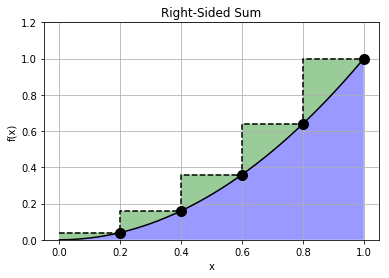

In [1]:
import riemann_sum_plots
riemann_sum_plots.right_sided_sum()

If instead we defined our sum to be

$$
  S =\frac{b-a}{n} \sum^{n}_{i=1} f \Bigg ( \frac{ (i-1)(b-a) }{n} + a \Bigg ) 
$$

the picture becomes

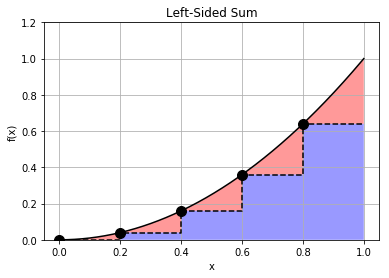

In [2]:
riemann_sum_plots.left_sided_sum()

**Exercise**: Both sums are only approximate.  Which *overestimate*, which *underestimates*, and is this always the case?

**Exercise**:  Consider the following two columns of data:

| $x$   | $\sqrt{x}$ |
|-------|------------|
|0.0000 | 0.0000     |
|0.3333 | 0.5774     |
|1.0000 | 1.0000     |
|1.5000 | 1.2247     |
|2.0000 | 1.4142     |

Estimate $\int^2_0 f(x) dx$ using the right-sided sum and left-sided sum.  Note that the $x$ points are **not evenly spaced**.

In [3]:
import numpy as np
x = np.array([0, 0.3333, 1.0000, 1.5000, 2.0000])
f = np.array([0, 0.5774, 1.0000, 1.2247, 1.4142])
dx = x[1:]-x[:-1]
I_rss = np.sum(dx * f[1:])
I_lss = np.sum(dx * f[:-1])
I_rss, I_lss,  (2/3)*(2**(3/2)), 0.5*(I_rss+I_lss)

(2.17859742, 1.4973025799999999, 1.8856180831641267, 1.83795)

## Beyond the One-Side Sums

We can do better.  As motivation, note that the central difference is nothing
but an *average* of the forward and backward differences:

$$
  \frac{1}{2} \Bigg ( \frac{f(x+h)-f(x)}{h} + \frac{f(x)-f(x-h)}{h} \Bigg ) = \frac{f(x+h)-f(x-h)}{2h}
$$

**Option I**: evaluate $f$ at the average (middle) $x$ points: 

$$
 S = \frac{b-a}{n} \sum^{n}_{i=1} f \Bigg ( \frac{ (i-1/2)(b-a) }{n} + a \Bigg ) 
$$
  
for which the picture becomes

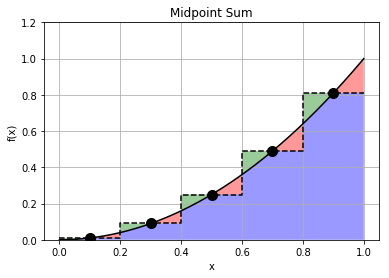

In [4]:
riemann_sum_plots.midpoint_sum()

**Option II**: Use the same points as one-sides sums, but *average* the $f$ values:

$$
\begin{split}
  S &= \frac{b-a}{2n} 
    \Bigg [ \sum^{n}_{i=1} f \Bigg ( \frac{ (i)(b-a) }{n} + a \Bigg ) 
         +  \sum^{n}_{i=1} f \Bigg ( \frac{ (i-1)(b-a) }{n} + a \Bigg ) \Bigg ] \\
    &= \frac{b-a}{2n} 
    \Bigg [ f(a) + f(b) + \sum^{n-1}_{i=1} f \Bigg ( \frac{ i(b-a) }{n} + a \Bigg ) \Bigg ]  
\end{split}
$$

This is the **trapezoid rule** for uniformly-spaced points. 

## What About Accuracy?

It is possible to determine the *order* of various numerical integration rules.  The basic idea is to observe the (absolute) error between an exact, reference value for an integral and the approximation of that integral for various step sizes $\Delta$.

**Exercise**:  Determine whether the right-sided and midpoint sums are first order or second order using the definite integral $\int^1_0 e^x dx = e - 1$ as a test case.  

## Using `scipy.integrate`

The module `scipy.integrate` provides several integration functions, including the powerful `quad` function:

```
In [99]: help(quad)
Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
```

**Exercise**:  Use `quad` to evaluate $\int^1_0 e^x dx = e - 1$.

**Exercise**:  Use `quad` to evaluate $\int^1_0 (ax^2 + bx + c)dx$ for $a=b=c=1$.

**Exercise**:  Use `dblquad` to evaluate the volume of the tetrahedron (i.e., triangular pyramid) that lies in the first octant and is bounded by the three coordinate planes (i.e., $xy$, $yz$, and $zx$ planes) and the plane
$z = 4 - 3x - y$.

In [5]:
from scipy.integrate import dblquad
dblquad(lambda y, x: 4-3*x-y, a=0, b=4/3, gfun=lambda x: 0, hfun=lambda x: 4 - 3*x)

(3.555555555555556, 8.84325393432354e-14)

## Recap


By the end of this lesson, you should be able to

- Evaluate definite integrals numerically using left- and right-sided Riemann sums, the mid-point rule, and the trapezoid rule.
- Evaluate definite integrals numerically using the built-in functions of `scipy.integrate`
- Establish the order of an integration scheme using numerical, graphical, or symbolic means (actually, this isn't covered, but I'm willing to bet you could do it with `series`!).

**Reminder**: Exam 2 is on Friday.  Exam from last year posted. Confirm ASAP (email, office hours) for accommodations.  